In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_csv('../Data/Clean/project_data_cleaned.csv', encoding='latin1')
df = df.drop("Unnamed: 0", axis = 1)

df.head().T

C:\Users\mattk\anaconda3\envs\msca\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
case_status,Denied,Certified-Expired,Denied,Certified,Denied
received_date,9/3/2009,3/29/2010,8/10/2010,2/3/2011,3/10/2011
decision_date,4/30/2020,10/18/2019,4/30/2020,5/28/2020,6/17/2020
employer_city,CHICAGO,GERMANTOWN,N. VALLEY STREAM,CAMPBELL,YONKERS
employer_state_province,ILLINOIS,MARYLAND,NEW YORK,CALIFORNIA,NEW YORK
employer_num_employees,2,0,3,29,43
emp_contact_city,chicago,GERMANTOWN,N. VALLEY STREAM,Sunnyvale,YONKERS
emp_contact_state_province,ILLINOIS,MARYLAND,NEW YORK,CALIFORNIA,NEW YORK
emp_contact_postal_code,60647,20874,11580,94086,10703
agent_attorney_name,Christopher E Kurczaba,WINSTON W TSAI,DANIEL J SULLIVAN,Sonal Kinger,VERNON L DUTTON


In [44]:
df.shape

(71942, 33)

In [45]:
df['received_date'] = pd.to_datetime(df['received_date'], format = '%m/%d/%Y')
df['decision_date'] = pd.to_datetime(df['decision_date'], format = '%m/%d/%Y')

df['wait_time'] = (df['decision_date'] - df['received_date'])/np.timedelta64(1, "M")

df['decision_month'] = df['decision_date'].dt.to_period('M')

df['age_of_business'] = 2020 - df.employer_year_commenced_business
df['age_of_business_cut'] = pd.qcut(df.age_of_business, 10)
df['naics_group'] = df.naics_code.astype(str).str[:2]

df['pw_wage'] = df.pw_wage.str.replace(',', '')
df['pw_wage'] = pd.to_numeric(df.pw_wage)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Hour", df.pw_wage*2080, df.pw_wage)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Week", df.pw_wage*52, df.pw_wage_adj)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Month", df.pw_wage*12, df.pw_wage_adj)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Bi-Weekly", df.pw_wage*26, df.pw_wage_adj)

In [37]:
pd.crosstab(df.decision_month, df.case_status)

case_status,Certified,Certified-Expired,Denied,Withdrawn
decision_month,,,,
2019-10,0,7029,408,290
2019-11,0,4980,236,274
2019-12,0,4063,326,327
2020-01,4453,255,235,307
2020-02,3369,0,348,238
2020-03,7028,0,259,299
2020-04,13130,0,299,287
2020-05,11554,0,332,463
2020-06,10374,0,439,340


I'm not sure I get how the data is structured... All cases decided in 2019 have a separate certification designation than those in 2020. The volume of decisions is much lower from Nov 2019 through Feb 2020 than the other months. 

Text(0.5, 1.0, 'Percent of Applications Accepted by Decision Month')

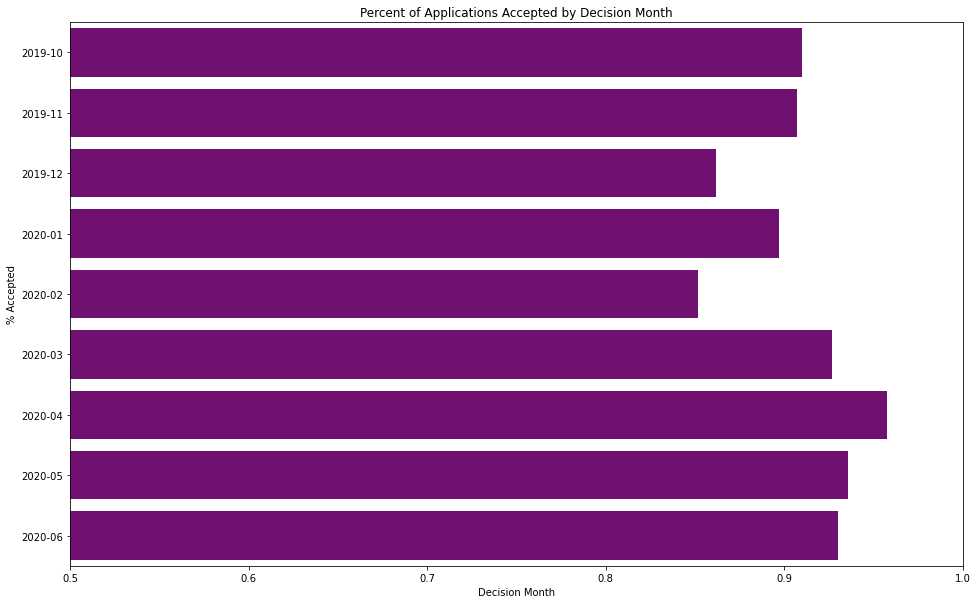

In [122]:
table = pd.crosstab(df.decision_month, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[['pct_accepted']]

plt.figure(figsize = (16, 10))

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple', orient='h')
ax.set(xlabel = 'Decision Month', ylabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Decision Month')

Text(0.5, 1.0, 'Percent of Applications Accepted by NAICS Group')

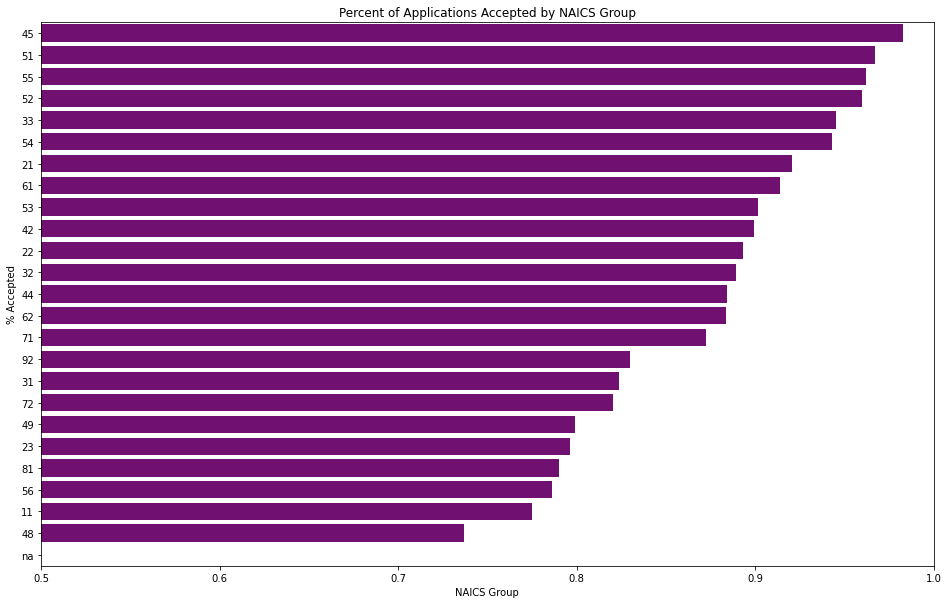

In [76]:
table = pd.crosstab(df.naics_group, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[['pct_accepted']].sort_values('pct_accepted', ascending=False)

plt.figure(figsize = (16, 10))

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'NAICS Group', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by NAICS Group')

NAICS Group Names
- 11	Agriculture, Forestry, Fishing and Hunting
- 21	Mining
- 22	Utilities
- 23	Construction
- 31	Manufacturing
- 32  Manufacturing
- 33  Manufacturing
- 42	Wholesale Trade
- 44  Retail Trade
- 45	Retail Trade
- 48  Transportation and Warehousing
- 49	Transportation and Warehousing
- 51	Information
- 52	Finance and Insurance
- 53	Real Estate Rental and Leasing
- 54	Professional, Scientific, and Technical Services
- 55	Management of Companies and Enterprises
- 56	Administrative and Support and Waste Management and Remediation Services
- 61	Educational Services
- 62	Health Care and Social Assistance
- 71	Arts, Entertainment, and Recreation
- 72	Accommodation and Food Services
- 81	Other Services (except Public Administration)
- 92	Public Administration

Text(0.5, 1.0, 'Percent of Applications Accepted by Visa Type')

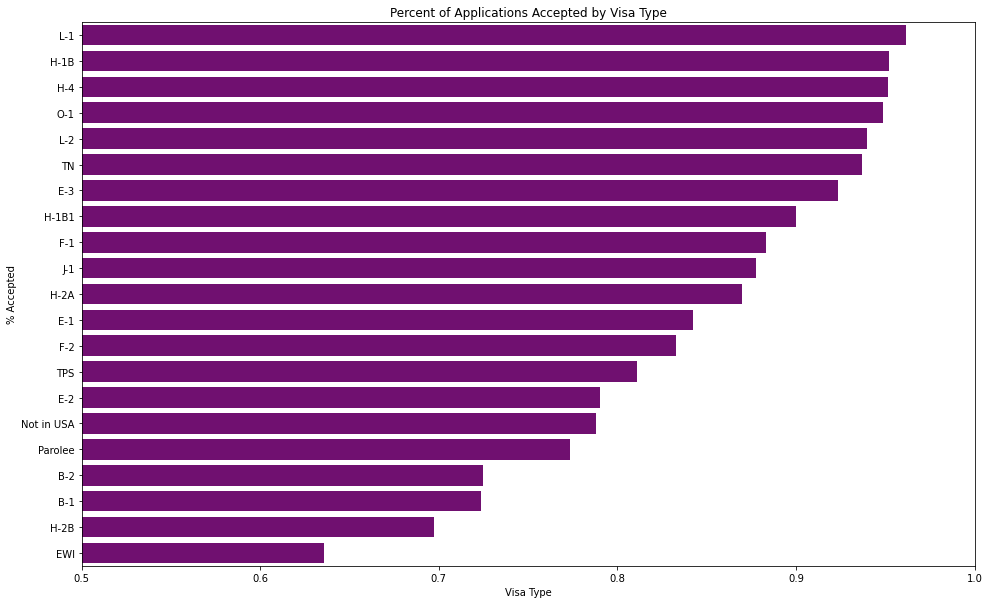

In [74]:
table = pd.crosstab(df.class_of_admission, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[table.sum(axis=1) > 50]
table = table[['pct_accepted']].sort_values('pct_accepted', ascending = False)

plt.figure(figsize = (16, 10))

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'Visa Type', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Visa Type')

Text(0.5, 1.0, 'Percent of Applications Accepted by Visa Type')

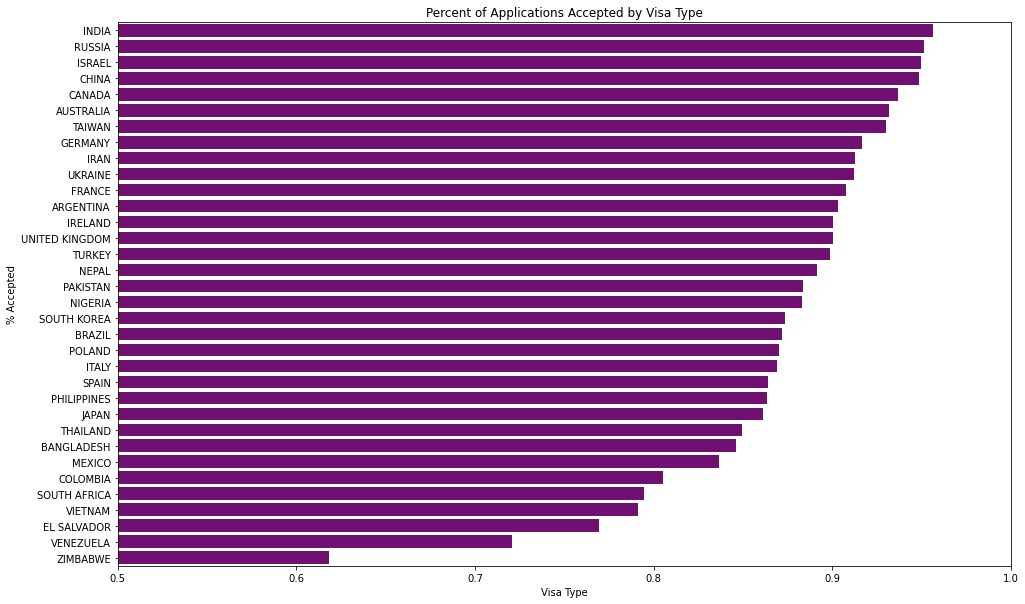

In [75]:
plt.figure(figsize = (16, 10))

table = pd.crosstab(df.country_of_citizenship, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[table.sum(axis=1) > 200]
table = table[['pct_accepted']].sort_values('pct_accepted', ascending=False)

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'Visa Type', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Visa Type')

Text(0.5, 1.0, 'Percent of Applications Accepted by Age of Business')

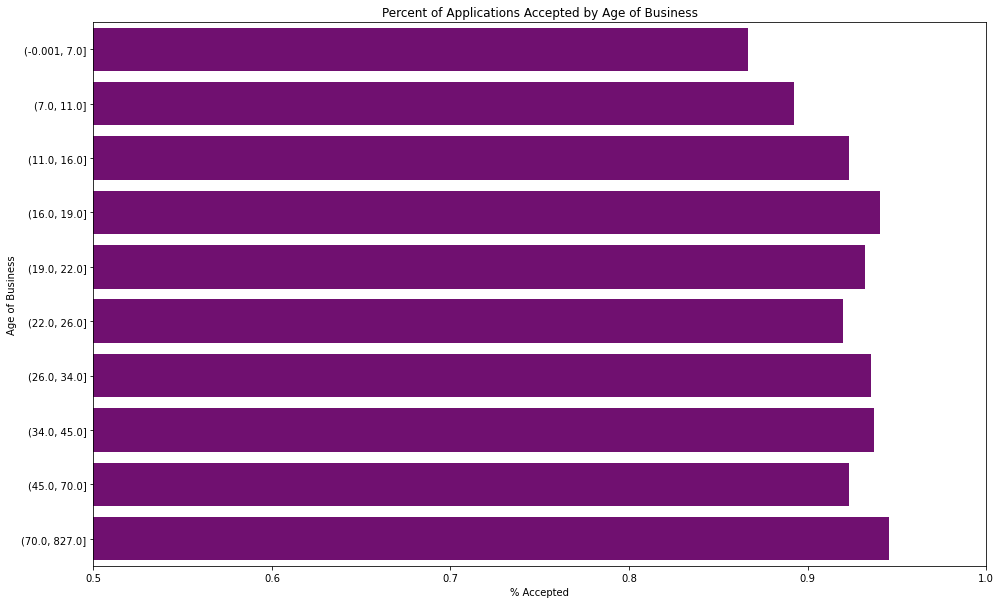

In [96]:
plt.figure(figsize = (16, 10))

table = pd.crosstab(df.age_of_business_cut, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[['pct_accepted']]

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'Age of Business', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Age of Business')

Text(0.5, 1.0, 'Percent of Applications Accepted by Age of Business')

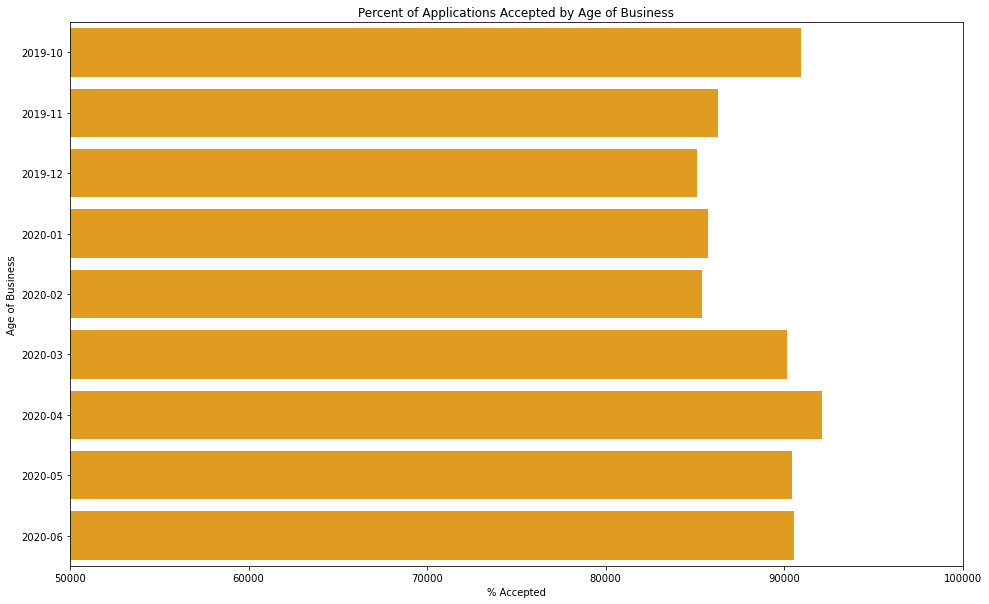

In [120]:
plt.figure(figsize = (16, 10))

table = df.groupby("decision_month", as_index=False)["pw_wage_adj"].mean()

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Decision Month', xlabel = 'Mean Salary', xlim=(50000, 100000))
ax.set_title('Mean Salary by Decision Month')

Text(0.5, 1.0, 'Mean Salary by NAICS Group')

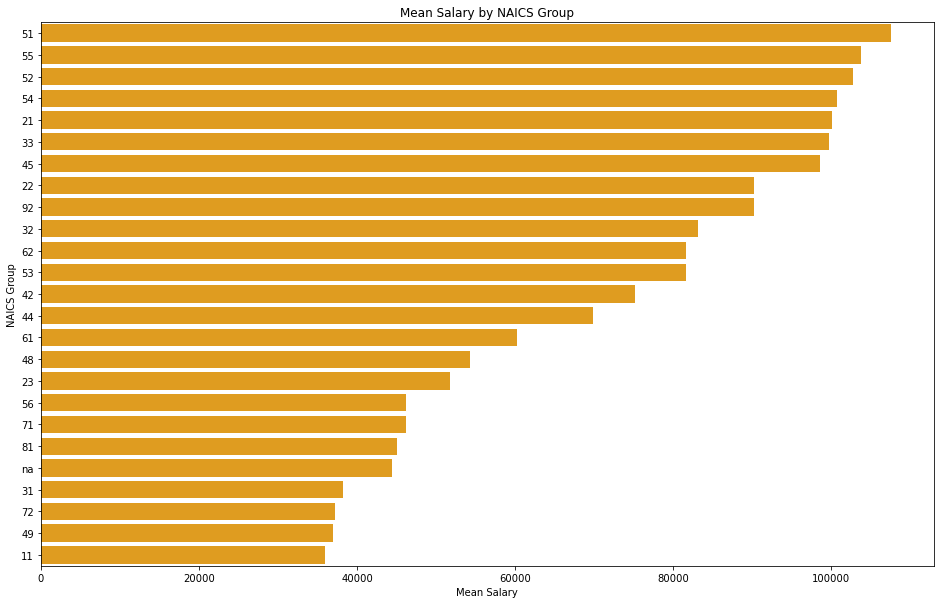

In [125]:
plt.figure(figsize = (16, 10))

table = df.groupby("naics_group", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(25)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'NAICS Group', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by NAICS Group')

Text(0.5, 1.0, 'Mean Salary by Visa Type')

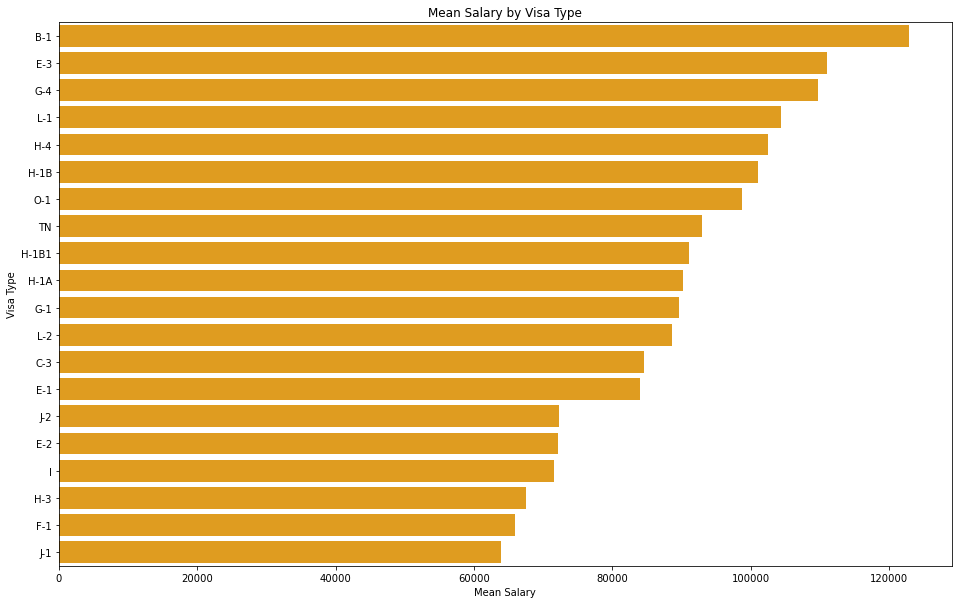

In [126]:
plt.figure(figsize = (16, 10))

table = df.groupby("class_of_admission", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(20)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Visa Type', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Visa Type')

Text(0.5, 1.0, 'Mean Salary by Country of Citizenship')

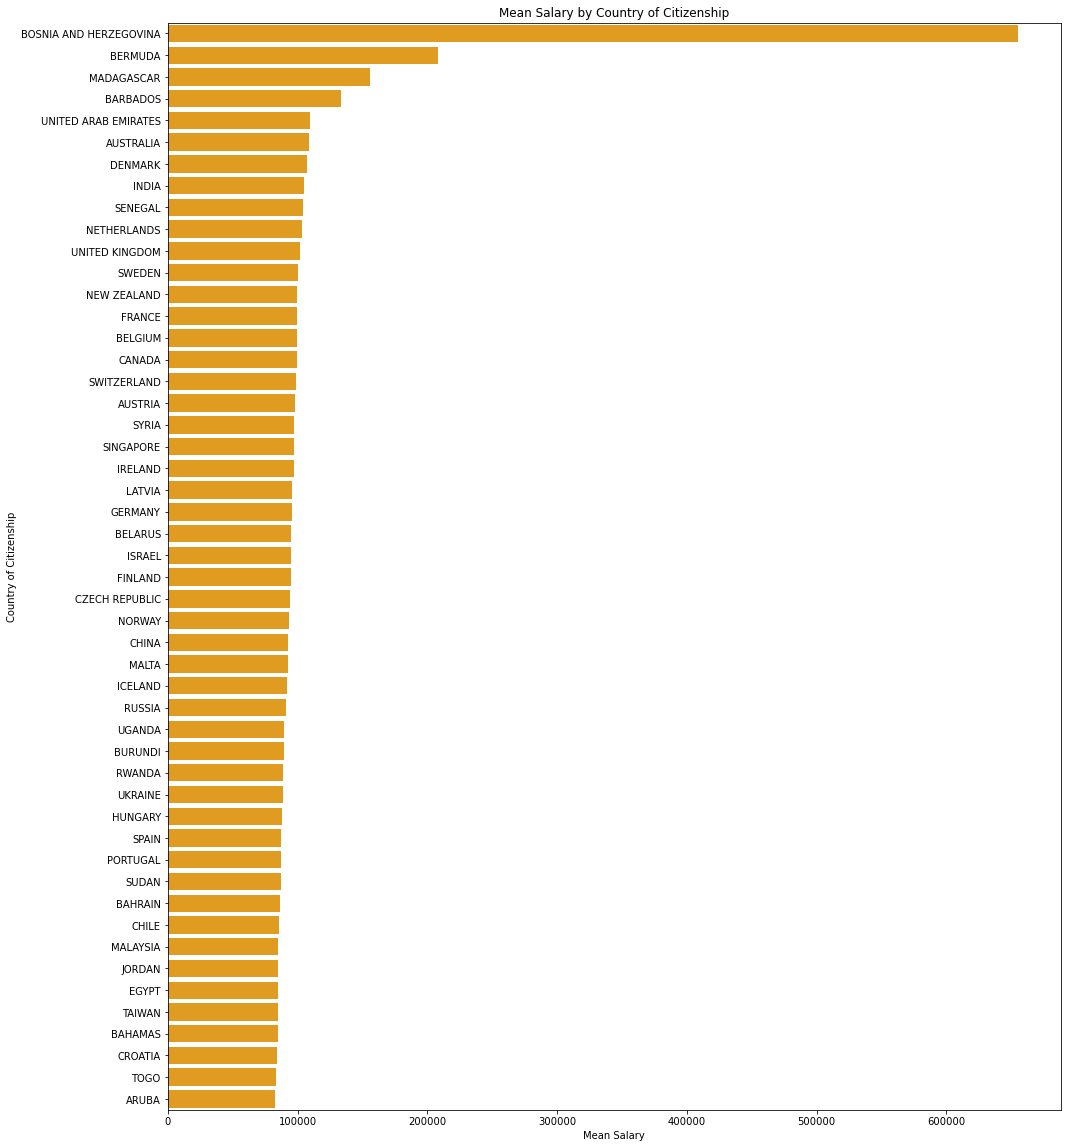

In [129]:
plt.figure(figsize = (16, 20))

table = df.groupby("country_of_citizenship", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(50)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Country of Citizenship', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Country of Citizenship')

Text(0.5, 1.0, 'Mean Salary by Age of Business')

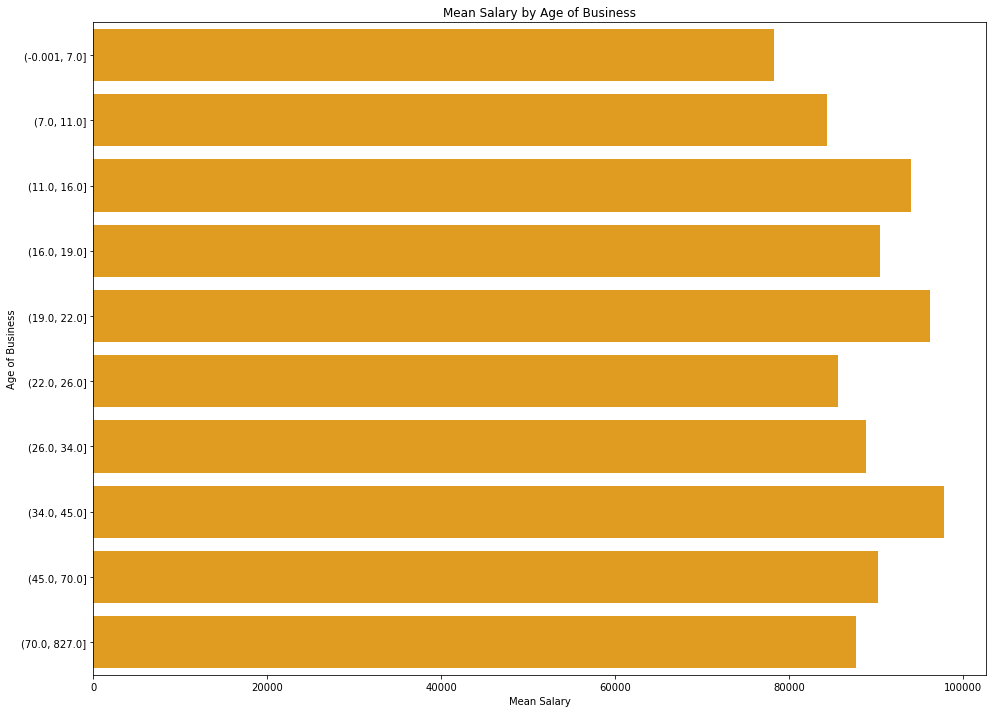

In [130]:
plt.figure(figsize = (16, 12))

table = df.groupby("age_of_business_cut", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(50)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Age of Business', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Age of Business')

Text(0.5, 1.0, 'Mean Wait Time by Decision Month')

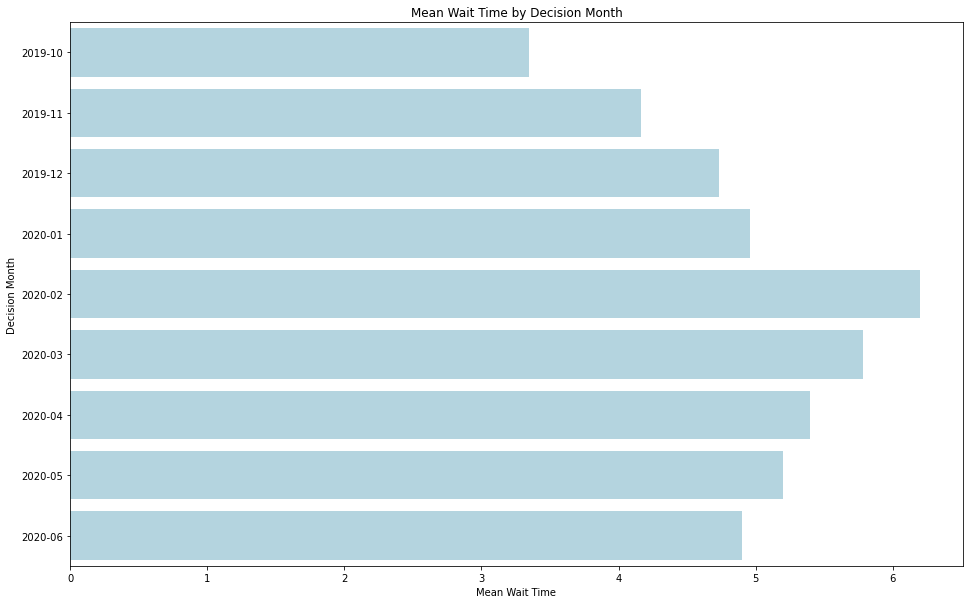

In [134]:
plt.figure(figsize = (16, 10))

table = df.groupby("decision_month", as_index=False)["wait_time"].mean()

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Decision Month', xlabel = 'Mean Wait Time')
ax.set_title('Mean Wait Time by Decision Month')

In [174]:
table

,naics_group,wait_time,count
0,11,6.349960,458
1,21,5.221751,151
2,22,4.880913,159
3,23,7.623825,1543
4,31,7.187313,1392
5,32,4.870737,1172
6,33,4.512154,7735
7,42,5.298588,1615
8,44,5.345588,1175
9,45,4.001179,3878


Text(0.5, 1.0, 'Mean Wait Time by NAICS Group')

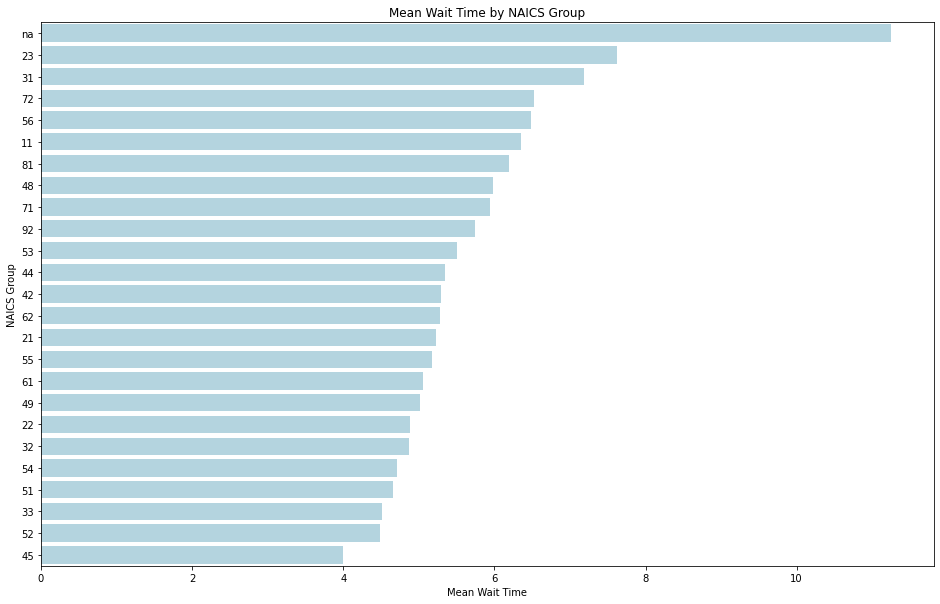

In [176]:
plt.figure(figsize = (16, 10))

table = df.groupby("naics_group", as_index=False)["wait_time"].mean()
table['count'] = table['naics_group'].map(df['naics_group'].value_counts())
table = table.sort_values('wait_time', ascending=False)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h', order = table['naics_group'])
ax.set(ylabel = 'NAICS Group', xlabel = 'Mean Wait Time')
ax.set_title('Mean Wait Time by NAICS Group')

Text(0.5, 1.0, 'Mean Wait Time by Visa Type')

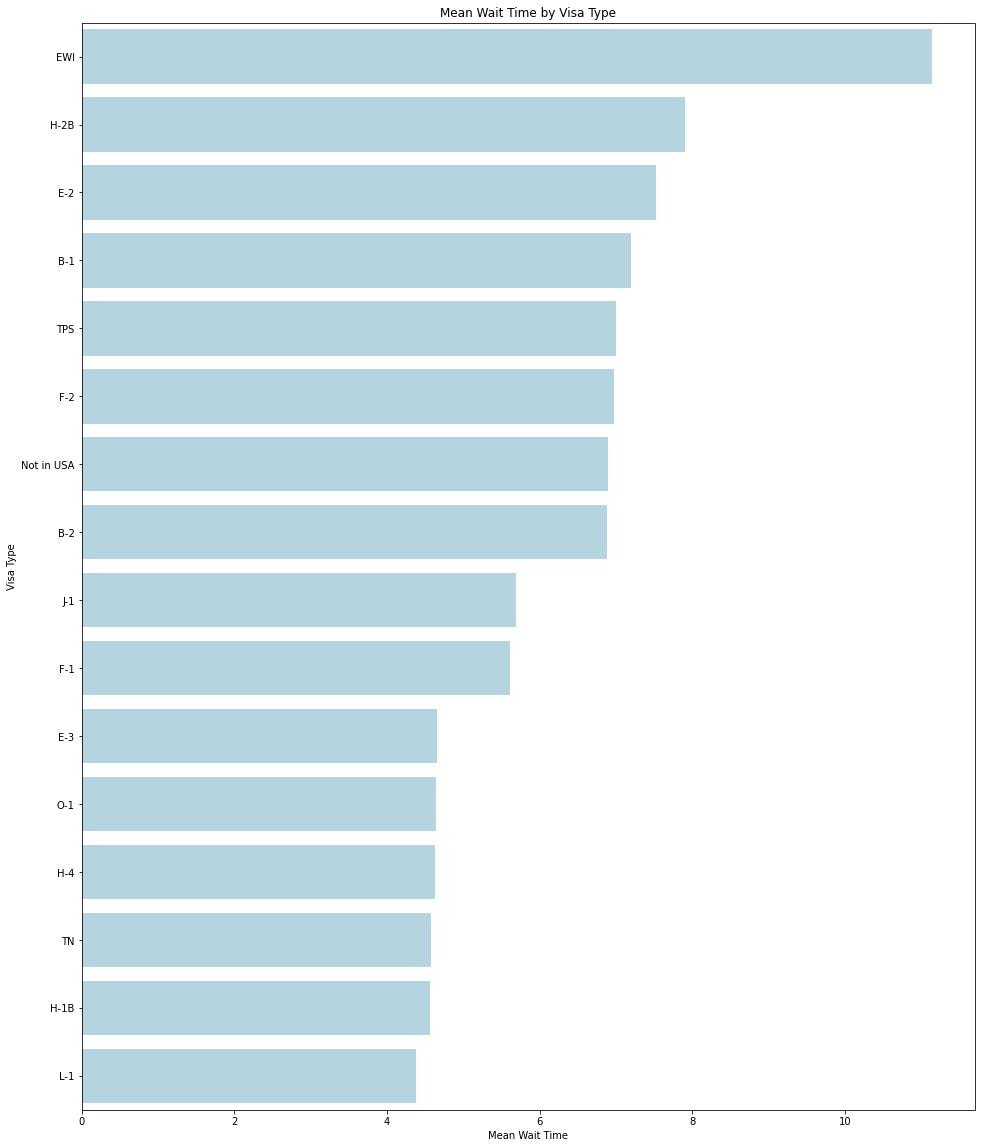

In [179]:
plt.figure(figsize = (16, 20))

table = df.groupby("class_of_admission", as_index=False)["wait_time"].mean().sort_values('wait_time', ascending=False)
table['count'] = table['class_of_admission'].map(df['class_of_admission'].value_counts())
table = table[table['count'] > 150]

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Visa Type', xlabel = 'Mean Wait Time')
ax.set_title('Mean Wait Time by Visa Type')

Text(0.5, 1.0, 'Mean Salary by Country of Citizenship')

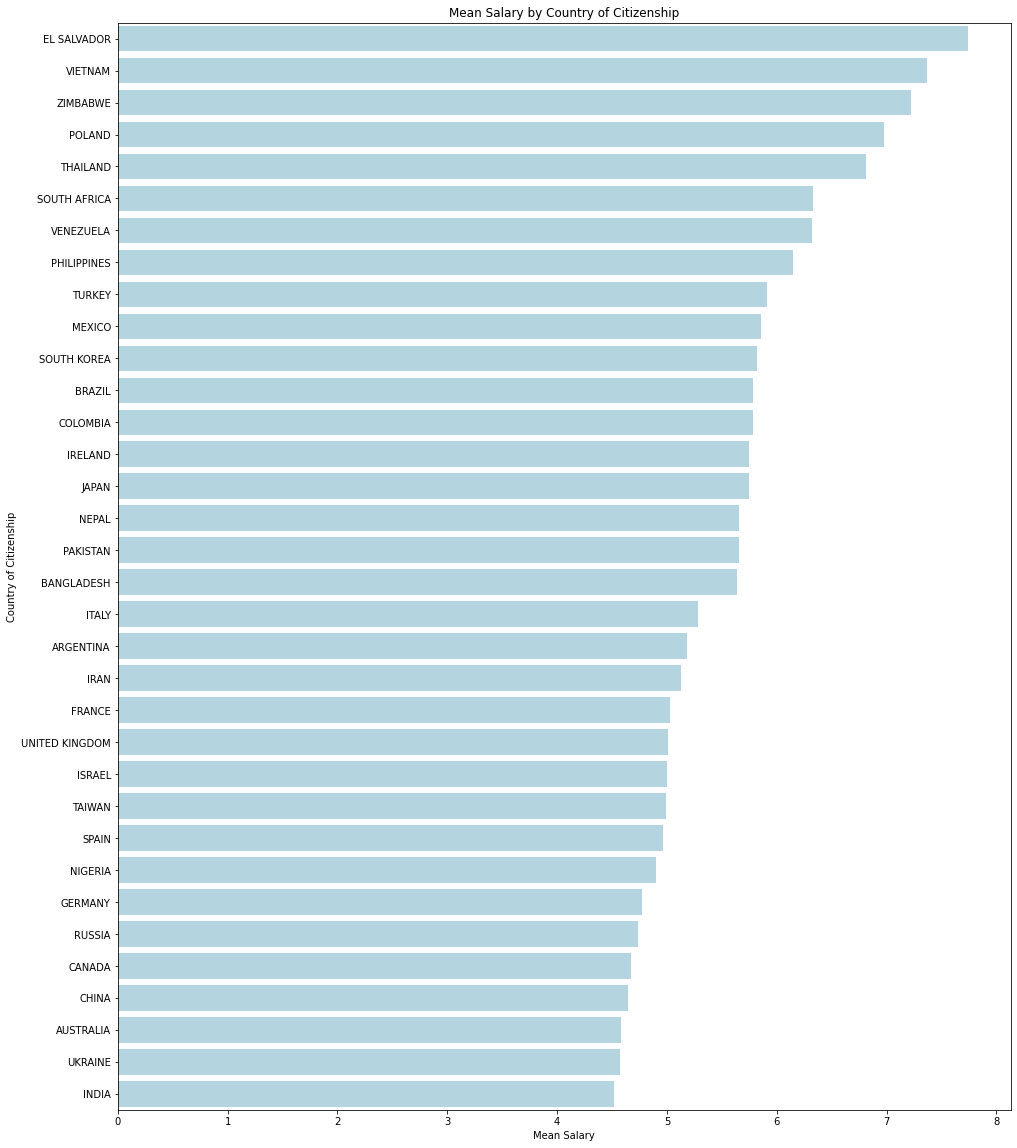

In [182]:
plt.figure(figsize = (16, 20))

table = df.groupby("country_of_citizenship", as_index=False)["wait_time"].mean()
table['count'] = table['country_of_citizenship'].map(df['country_of_citizenship'].value_counts())
table = table[table['count'] > 200].sort_values('wait_time', ascending=False)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Country of Citizenship', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Country of Citizenship')

Text(0.5, 1.0, 'Mean Salary by Age of Business')

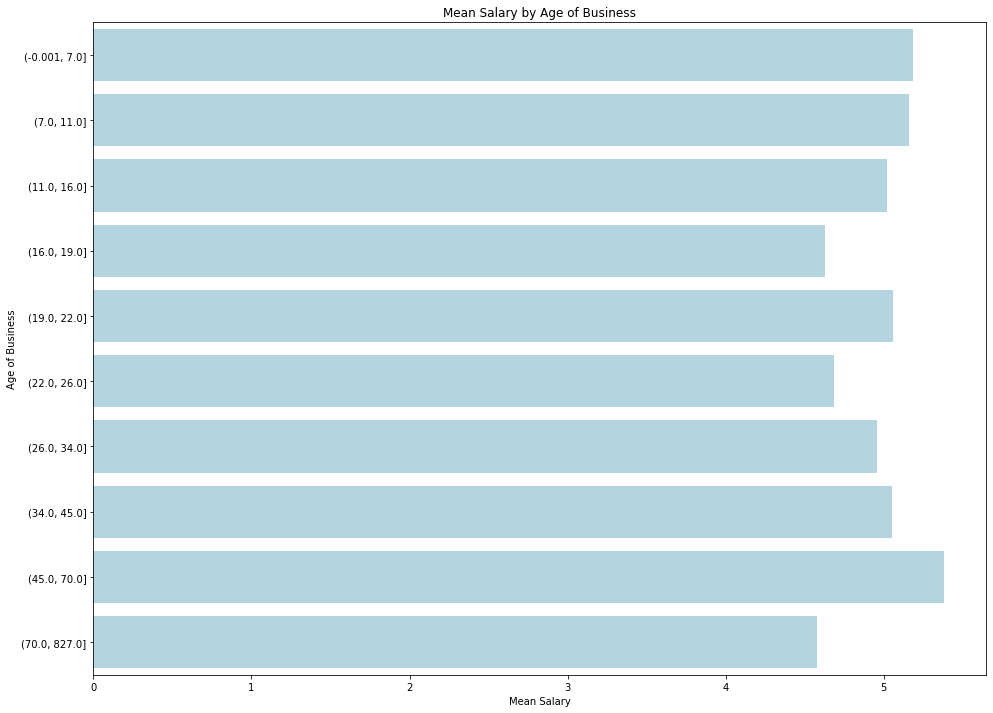

In [184]:
plt.figure(figsize = (16, 12))

table = df.groupby("age_of_business_cut", as_index=False)["wait_time"].mean()
table['count'] = table['age_of_business_cut'].map(df['age_of_business_cut'].value_counts())
table = table.sort_values('wait_time', ascending=False)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Age of Business', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Age of Business')